In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys

%matplotlib inline
from IPython import display


import functions.parse_data as parse
import functions.handy_functions as hf
import torch.nn as nn
import torch


from multivariate_quantile_regression.network_model import QuantileNetwork

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from tqdm import tqdm

import os

import netCDF4 as nc
import glob

from functions.plot_metrics import plot_metrics
from functions.plot_metrics_one import plot_metrics_one
from functions import calc_metrics

In [44]:
data_water=parse.parse('cloudrm2_water.dat')
data_clear=parse.parse('cloudrm2_clear.dat')
data_ice=parse.parse('cloudrm2_ice.dat')
data_mixed=parse.parse('cloudrm2_mixed.dat')

#Concatinate all datasets
#data_all=pd.concat([data_water,data_clear,data_ice,data_mixed,
#                    data_black_water,data_black_clear,data_black_ice,data_black_mixed])
data_all=pd.concat([data_water,data_clear,data_ice,data_mixed])


data_all=data_all.drop(columns=['Surface_Desc','Cloud_B01','Clear_B01'])
data_all=data_all.reset_index()
data_all=data_all.drop(columns=('index'))

df=data_all.copy()

X_labels= ['Cloud_B02','Cloud_B03','Cloud_B04','Cloud_B05','Cloud_B06',
           'Cloud_B07','Cloud_B08','Cloud_B09','Cloud_B10','Cloud_B11','Cloud_B12','Cloud_B13']
#Leave out 'GOT', 'Water_Vapor'
#Band 1 no go.
y_labels=['Clear_B02','Clear_B03','Clear_B04','Clear_B05',
              'Clear_B06','Clear_B07','Clear_B08', 'Clear_B09',
              'Clear_B10','Clear_B11','Clear_B12','Clear_B13']
#clear_labels=['Clear_B02','Clear_B03','Clear_B04','Clear_B05',
#              'Clear_B06','Clear_B07','Clear_B08', 'Clear_B09',
#              'Clear_B10','Clear_B11','Clear_B12','Clear_B13']

#y_labels= ['OCloud_B02','OCloud_B03','OCloud_B04','OCloud_B05','OCloud_B06',
#           'OCloud_B07','OCloud_B08','OCloud_B09','OCloud_B10','OCloud_B11','OCloud_B12','OCloud_B13']

#df[y_labels]=df[X_labels].to_numpy()-df[clear_labels].to_numpy()

In [45]:
X=df[X_labels]
y=df[y_labels]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

In [46]:
X_train = X_train + np.random.randn(np.shape(X_train)[0],np.shape(X_train)[1]) * np.mean(X_train.to_numpy(),axis=0)*0.03
X_test = X_test + np.random.randn(np.shape(X_test)[0],np.shape(X_test)[1]) * np.mean(X_test.to_numpy(),axis=0)*0.03

In [47]:
#Normalise
X_mean=np.mean(X_train,axis=0).to_numpy()
X_std=np.std(X_train,axis=0).to_numpy()
X_train=(X_train-X_mean)/X_std

X_test=(X_test-X_mean)/X_std


In [48]:
print(np.mean(X_train,axis=0).to_numpy())
print(np.std(X_train,axis=0).to_numpy())
print(" ")
print(np.mean(X_test,axis=0).to_numpy())
print(np.std(X_test,axis=0).to_numpy())

[-2.60236277e-16 -3.38129524e-16 -7.85860266e-16  8.02380384e-16
  3.78030940e-16  7.80975284e-16  3.95128374e-16  1.09028342e-15
 -1.92512672e-16  5.06261699e-18  5.23669996e-16  5.04840614e-16]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 
[ 0.01312445  0.01457208  0.01537319  0.01232325  0.00583362  0.00465882
  0.00393189  0.00591931  0.00139593  0.00179879 -0.00563189  0.00121926]
[1.00032219 1.00146953 1.00113393 1.00369594 0.99559672 0.99585248
 0.99518696 0.99671608 1.00056075 1.00360268 0.99835909 1.00154268]


In [49]:
def custom_learning_rate(iterations):
  """
  This function reduces the learning rate by 0.1 every 10 iterations.
  """
  return 0.1 * (1.0 - (iterations / 10))

In [58]:
import cupy as cp
import xgboost as xgb
# Define your training and target data (replace with your actual data)
# Your training features
# Your training target values

# Create the XGBoost regressor model
X_train_gpu = cp.asarray(X_train.to_numpy())
y_train_gpu = cp.asarray(y_train.to_numpy())

model = xgb.XGBRegressor(device='cuda',n_estimators=500,
                         max_depth=5,
                         learning_rates=custom_learning_rate,
                         loss='squared_error')

# Train the model on the training data
model.fit(X_train_gpu, y_train_gpu)

# Make predictions on new data (replace with your new data)
X_new = X_test# Your new features
y_pred = model.predict(X_new)


/home/edgelab/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:36:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "loss" } are not used.

  warnings.warn(smsg, UserWarning)


In [59]:
mean_squared_error(y_test,y_pred)

0.009474019489002923

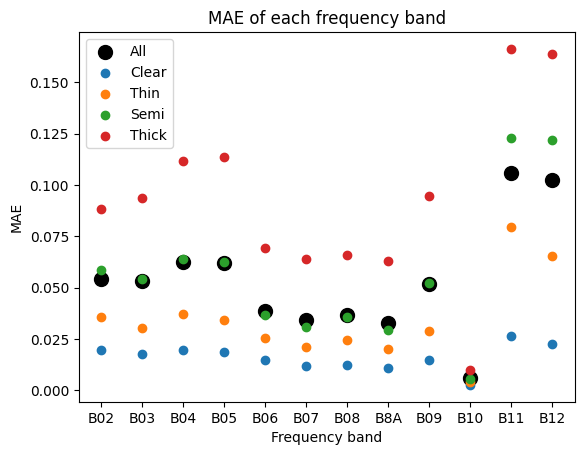

In [60]:
testindices=y_test.index
COTs=np.array(df['COT'].iloc[testindices])

#Divide into bins depending on COT
clear_true = y_test.to_numpy()[(COTs==0),:]
clear_pred = y_pred[(COTs==0),:]
thin_true = y_test.to_numpy()[(COTs>0) &  (COTs<3.6),:]
thin_pred = y_pred[(COTs>0) & (COTs<3.6),:]
semi_true = y_test.to_numpy()[(COTs>=3.6) & (COTs<23),:]
semi_pred = y_pred[(COTs>=3.6) & (COTs<23),:]
thick_true = y_test.to_numpy()[(COTs>=23),:]
thick_pred = y_pred[(COTs>=23),:]


#Find and print MAE of each band
MAE_col_tot = np.mean(np.abs(y_test.to_numpy()-y_pred),axis=0)
MAE_col_clear = np.mean(np.abs(clear_true-clear_pred),axis=0)
MAE_col_thin = np.mean(np.abs(thin_true-thin_pred),axis=0)
MAE_col_semi = np.mean(np.abs(semi_true-semi_pred),axis=0)
MAE_col_thick = np.mean(np.abs(thick_true-thick_pred),axis=0)

x=np.arange(np.size(MAE_col_tot))
plt.figure()
plt.scatter(x,MAE_col_tot,c='black',s=100)
plt.scatter(x,MAE_col_clear)
plt.scatter(x,MAE_col_thin)
plt.scatter(x,MAE_col_semi)
plt.scatter(x,MAE_col_thick)
plt.xticks(x, ['B02','B03','B04','B05','B06','B07','B08','B8A','B09','B10','B11','B12'])
plt.title('MAE of each frequency band')
plt.xlabel('Frequency band')
plt.ylabel('MAE')
plt.legend(['All','Clear','Thin','Semi','Thick'])
plt.show()

/home/edgelab/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/edgelab/.local/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/edgelab/.local/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Text(0, 0.5, 'Ground Truth')

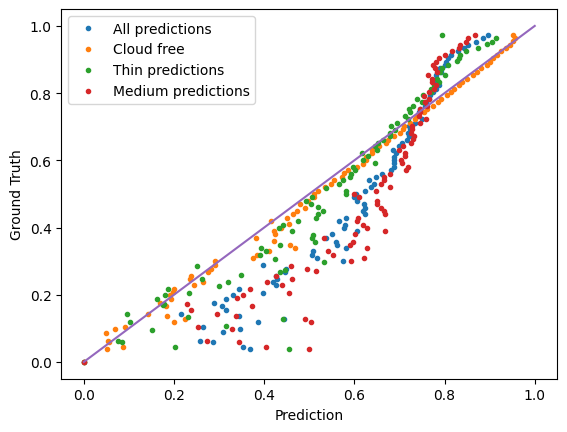

In [65]:
band=10
## Prediction v Ground Truth ##
y_true=y_test.to_numpy()[:,band]
pred_y_11=y_pred[:,band]
bins=np.linspace(0,1,100)

freq_true=np.zeros(len(bins))
freq_pred=np.zeros(len(bins))

freq_true_zero=np.zeros(len(bins))
freq_pred_zero=np.zeros(len(bins))

freq_true_thin=np.zeros(len(bins))
freq_pred_thin=np.zeros(len(bins))

freq_true_med=np.zeros(len(bins))
freq_pred_med=np.zeros(len(bins))

y_tmp_zero=clear_true[:,band]
y_tmp_thin=thin_true[:,band]
y_tmp_med=semi_true[:,band]

y_tmp_pred_zero=clear_pred[:,band]
y_tmp_pred_thin=thin_pred[:,band]
y_tmp_pred_med=semi_pred[:,band]

for j,edge in enumerate(bins):
    if j!=0:
        indices=(y_true>bins[j-1])&(y_true<=edge)

        ind_z=(y_tmp_zero>bins[j-1])&(y_tmp_zero<=edge)
        ind_t=(y_tmp_thin>bins[j-1])&(y_tmp_thin<=edge)
        ind_m=(y_tmp_med>bins[j-1])&(y_tmp_med<=edge)

        mean_bin_true=np.mean(y_true[indices])
        mean_bin_pred=np.mean(pred_y_11[indices])

        mean_bin_true_zero=np.mean(y_tmp_zero[ind_z])
        mean_bin_pred_zero=np.mean(y_tmp_pred_zero[ind_z])

        mean_bin_true_thin=np.mean(y_tmp_thin[ind_t])
        mean_bin_pred_thin=np.mean(y_tmp_pred_thin[ind_t])

        mean_bin_true_med=np.mean(y_tmp_med[ind_m])
        mean_bin_pred_med=np.mean(y_tmp_pred_med[ind_m])
        
        freq_true[j]=mean_bin_true
        freq_pred[j]=mean_bin_pred

        freq_true_zero[j]=mean_bin_true_zero
        freq_pred_zero[j]=mean_bin_pred_zero

        freq_true_thin[j]=mean_bin_true_thin
        freq_pred_thin[j]=mean_bin_pred_thin

        freq_true_med[j]=mean_bin_true_med
        freq_pred_med[j]=mean_bin_pred_med

plt.plot(freq_pred,freq_true,'.')
plt.plot(freq_pred_zero,freq_true_zero,'.')
plt.plot(freq_pred_thin,freq_true_thin,'.')
plt.plot(freq_pred_med,freq_true_med,'.')
#plt.plot(cloudy_sort,'.')
line=np.linspace(0,1,100)
plt.plot(line,line)
plt.legend(['All predictions','Cloud free','Thin predictions','Medium predictions'])
plt.xlabel("Prediction")
plt.ylabel("Ground Truth")

In [62]:
test_indices=X_test.index
df_test=df.loc[test_indices]
df_test=df_test.reset_index()
df_test_clear=df_test[df_test['COT']==0]
df_test_thin=df_test[(df_test['COT']<=3.6) & (df_test['COT']>0)]
df_test_med=df_test[(df_test['COT']<=23) & (df_test['COT']>3.6)]
df_test_thick=df_test[(df_test['COT']<=50) & (df_test['COT']>23)]

In [63]:

MSE_cot_levels=[]
MSE_cot_levels.append(mean_squared_error(y_test.to_numpy(),y_pred))
MSE_cot_levels.append(mean_squared_error(y_test.to_numpy()[df_test_clear.index],y_pred[df_test_clear.index,:]))
MSE_cot_levels.append(mean_squared_error(y_test.to_numpy()[df_test_thin.index],y_pred[df_test_thin.index,:]))
MSE_cot_levels.append(mean_squared_error(y_test.to_numpy()[df_test_med.index],y_pred[df_test_med.index,:]))
MSE_cot_levels.append(mean_squared_error(y_test.to_numpy()[df_test_thick.index],y_pred[df_test_thick.index,:]))

In [64]:
print("MSE all test data: "+str(MSE_cot_levels[0]))
print("MSE clear test data: "+str(MSE_cot_levels[1]))
print("MSE thin COT <3.6 test data: "+str(MSE_cot_levels[2]))
print("MSE med COT <23 test data: "+str(MSE_cot_levels[3]))
print("MSE thick COT <50 test data: "+str(MSE_cot_levels[4]))

MSE all test data: 0.009474019489002923
MSE clear test data: 0.0008833538284015405
MSE thin COT <3.6 test data: 0.003977456733316624
MSE med COT <23 test data: 0.008920455643931622
MSE thick COT <50 test data: 0.020581135985769647
